# Plotting Model runs
This notebook is for comparing model output - especially used during hyperparameter training. 
The function employed are for reading the .csv model output files (with meta data) and plotting test or train data as a single plot or as a comparison of multiple values of one hyperparameter.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Functions


In [2]:
# Functions for reading .csv file containing data and metadata 

def read_metrics_csv_flexible(filepath):
    """
    Function to read metrics from CSV files with varying metadata formats.
    Finds the 'epoch' header dynamically and parses all metadata above it.
    
    Returns:
        metadata (dict): Dictionary containing all parsed metadata
        df: Pandas DataFrame with the data
    """
    with open(filepath, 'r') as f:
        lines = f.readlines()
    
    # Find the line with 'epoch' header (start of actual data)
    data_start_line = None
    for i, line in enumerate(lines):
        if line.strip().startswith('epoch'):
            data_start_line = i
            break
    
    if data_start_line is None:
        raise ValueError("Could not find 'epoch' header in CSV file")
    
    # Initialize metadata dictionary
    metadata = {}
    
    # Parse the first line (always contains model and timestamp)
    first_line = lines[0].strip()
    if first_line.startswith("Metrics for "):
        model_line = first_line.replace("Metrics for ", "")
        if " at " in model_line:
            model, timestamp = model_line.split(" at ")
            metadata["model"] = model
            metadata["timestamp"] = timestamp
    
    # Parse all lines before the data starts
    for i in range(1, data_start_line):
        line = lines[i].strip()
        
        # Skip empty lines and section headers
        if not line or line == "Hyperparameters":
            continue
            
        # Parse key-value pairs
        if "," in line:
            parts = line.split(",", 1)  # Split only on first comma
            if len(parts) == 2:
                key, value = parts[0].strip(), parts[1].strip()
                
                # Try to convert to appropriate type
                if key.lower() in ["momentum", "learning_rate", "weight_decay"]:
                    try:
                        metadata[key.lower()] = float(value)
                    except ValueError:
                        metadata[key.lower()] = value
                elif key.lower() in ["batch_size", "num_epochs", "test_every_x_epochs"]:
                    try:
                        metadata[key.lower()] = int(value)
                    except ValueError:
                        metadata[key.lower()] = value
                elif key.lower() == "optimizer":
                    metadata["optimizer"] = value
                elif key.lower().replace(" ", "_").replace("(", "").replace(")", "").replace(":", "") == "training_time_hhmmss":
                    metadata["training_time"] = value
                else:
                    # For any other key, try to determine type automatically
                    try:
                        # Try int first
                        if "." not in value:
                            metadata[key.lower()] = int(value)
                        else:
                            metadata[key.lower()] = float(value)
                    except ValueError:
                        # If conversion fails, store as string
                        metadata[key.lower()] = value
    
    # Read the actual metrics data
    df = pd.read_csv(filepath, skiprows=data_start_line)
    
    return metadata, df

In [3]:
# Functions for plotting

def plot_single_mobilenet(meta, df):
    '''
    Plots train & test loss & acc. of one hyperparameter value in the same plot
    For ViT (only needed for title)
    Input:
    meta - meta data of the csv file
    df - actual data of the csv file
    Output:
    Plot'''
    df = df.dropna()    
    fig, ax1 = plt.subplots(figsize=(8, 5))    
    # Plot loss on primary y-axis (left)    
    ax1.plot(df.epoch, df.train_loss, label='Train Loss', color='tab:blue')    
    ax1.plot(df.epoch, df.test_loss, label='Test Loss', color='tab:cyan')    
    ax1.set_xlabel('Epoch')    
    ax1.set_ylabel('Loss (Cross Entropy)')    
    ax1.tick_params(axis='y')    
    ax1.grid(True)    
    # Create secondary y-axis (right) for accuracy    
    ax2 = ax1.twinx()    
    ax2.plot(df.epoch, df.train_acc, label='Train Acc', color='tab:orange')    
    ax2.plot(df.epoch, df.test_acc, label='Test Acc', color='tab:red')    
    ax2.set_ylabel('Accuracy')    
    ax2.tick_params(axis='y')    
    # Combine legends from both axes    
    lines, labels = ax1.get_legend_handles_labels()    
    lines2, labels2 = ax2.get_legend_handles_labels()    
    ax1.legend(lines + lines2, labels + labels2, loc='center right')    
    plt.title(        
        f"MobileNet - LR: {meta['learning_rate']}"        
        f"{' - Optimizer: ' + str(meta['optimizer']) if 'optimizer' in meta else ''}"        
        f"{' - Momentum: ' + str(meta['momentum']) if 'optimizer' in meta and meta['optimizer'] == 'sgd' else ''}"       
        f"{' - Weight Decay: ' + str(meta['weight_decay']) if 'optimizer' in meta and meta['optimizer'] == 'adamw' else ''}"       
        f" - Batch size: {meta['batch_size']}")    
    plt.tight_layout() 
    #plt.savefig(f'C:\\Users\\Farmer\\Desktop\\Images\\{meta["timestamp"]}.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.show()

# Same for ViT
def plot_single_vit(meta, df): 
    '''
    Plots train & test loss & acc. of one hyperparameter value in the same plot
    For ViT (only needed for title)
    Input:
    meta - meta data of the csv file
    df - actual data of the csv file
    Output:
    Plot'''  

    df = df.dropna()    
    fig, ax1 = plt.subplots(figsize=(8, 5))    
    # Plot loss on primary y-axis (left)    
    ax1.plot(df.epoch, df.train_loss, label='Train Loss', color='tab:blue')    
    ax1.plot(df.epoch, df.test_loss, label='Test Loss', color='tab:cyan')    
    ax1.set_xlabel('Epoch')    
    ax1.set_ylabel('Loss (Cross Entropy)')    
    ax1.tick_params(axis='y')    
    ax1.grid(True)    
    # Create secondary y-axis (right) for accuracy    
    ax2 = ax1.twinx()    
    ax2.plot(df.epoch, df.train_acc, label='Train Acc', color='tab:orange')    
    ax2.plot(df.epoch, df.test_acc, label='Test Acc', color='tab:red')    
    ax2.set_ylabel('Accuracy')    
    ax2.tick_params(axis='y')    
    # Combine legends from both axes    
    lines, labels = ax1.get_legend_handles_labels()    
    lines2, labels2 = ax2.get_legend_handles_labels()    
    ax1.legend(lines + lines2, labels + labels2, loc='center right')    
    plt.title(        
        f"ViT - LR: {meta['learning_rate']}"        
        f"{' - Optimizer: ' + str(meta['optimizer']) if 'optimizer' in meta else ''}"        
        f"{' - Momentum: ' + str(meta['momentum']) if 'optimizer' in meta and meta['optimizer'] == 'sgd' else ''}"       
        f"{' - Weight Decay: ' + str(meta['weight_decay']) if 'optimizer' in meta and meta['optimizer'] == 'adamw' else ''}"       
        f" - Batch size: {meta['batch_size']}")    
    plt.tight_layout() 
    #plt.savefig(f'C:\\Users\\Farmer\\Desktop\\Images\\{meta["timestamp"]}.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.show()

# Same for Resnet
def plot_single_resnet(meta, df):
    '''
    Plots train & test loss & acc. of one hyperparameter value in the same plot
    For ViT (only needed for title)
    Input:
    meta - meta data of the csv file
    df - actual data of the csv file
    Output:
    Plot'''
    df = df.dropna()    
    fig, ax1 = plt.subplots(figsize=(8, 5))    
    # Plot loss on primary y-axis (left)    
    ax1.plot(df.epoch, df.train_loss, label='Train Loss', color='tab:blue')    
    ax1.plot(df.epoch, df.test_loss, label='Test Loss', color='tab:cyan')    
    ax1.set_xlabel('Epoch')    
    ax1.set_ylabel('Loss (Cross Entropy)')    
    ax1.tick_params(axis='y')    
    ax1.grid(True)    
    # Create secondary y-axis (right) for accuracy    
    ax2 = ax1.twinx()    
    ax2.plot(df.epoch, df.train_acc, label='Train Acc', color='tab:orange')    
    ax2.plot(df.epoch, df.test_acc, label='Test Acc', color='tab:red')    
    ax2.set_ylabel('Accuracy')    
    ax2.tick_params(axis='y')    
    # Combine legends from both axes    
    lines, labels = ax1.get_legend_handles_labels()    
    lines2, labels2 = ax2.get_legend_handles_labels()    
    ax1.legend(lines + lines2, labels + labels2, loc='center right')    
    plt.title(        
        f"Resnet - LR: {meta['learning_rate']}"        
        f"{' - Optimizer: ' + str(meta['optimizer']) if 'optimizer' in meta else ''}"        
        f"{' - Momentum: ' + str(meta['momentum']) if 'optimizer' in meta and meta['optimizer'] == 'sgd' else ''}"       
        f"{' - Weight Decay: ' + str(meta['weight_decay']) if 'optimizer' in meta and meta['optimizer'] == 'adamw' else ''}"       
        f" - Batch size: {meta['batch_size']}")    
    plt.tight_layout() 
    #plt.savefig(f'C:\\Users\\Farmer\\Desktop\\Images\\{meta["timestamp"]}.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.show()

# Compare different values of the same hyperparameter
def plot_comp_vit(quantity, hp_list, hp, hp_var):
    '''Plot a comparison of different runs of one varying hyperparamter    
    - hp: Name of hyperparameter for title   
    - hp_var: Name of hyperparameter variable    
    - hp_table: list with different csv. runs    
    - qunantity: quantity to plot (i.e. test_acc, etc.)    
    '''    
    for item in hp_list:         
        meta, df = read_metrics_csv_flexible(f"../outputs_vit/csv/{hp_list[item]}")        
        df = df.dropna()        
        plt.plot(df['epoch'],df[quantity], label = item)        
    plt.xlabel('Epoch')    
    plt.ylabel(f'{quantity}')    
    plt.title(    
        f"Comparison {hp} - ViT {' - LR: ' + str(meta['learning_rate']) if hp_var != 'learning_rate' else ''}"    
        f"{' - Optimizer: ' + str(meta['optimizer']) if hp_var != 'optimizer' and 'optimizer' in meta else ''}"    
        f"{' - Momentum: ' + str(meta['momentum']) if 'optimizer' in meta and meta['optimizer'] == 'sgd' and hp_var != 'momentum' else ''}"    
        f"{' - Weight Decay: ' + str(meta['weight_decay']) if 'optimizer' in meta and meta['optimizer'] == 'adamw' and hp_var != 'weight_decay' else ''}"    
        f"{' - Batch size: ' + str(meta['batch_size']) if hp_var != 'batch_size' else '' }")    
    plt.legend()    
    plt.tight_layout()    
    plt.grid()
    #plt.savefig(f'C:\\Users\\Farmer\\Desktop\\Images\\{meta["timestamp"]}.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.show()

def plot_comp_resnet(quantity, hp_list, hp, hp_var):
    '''Plot a comparison of different runs of one varying hyperparamter    
    - hp: Name of hyperparameter for title   
    - hp_var: Name of hyperparameter variable    
    - hp_table: list with different csv. runs    
    - qunantity: quantity to plot (i.e. test_acc, etc.)    
    '''    
    for item in hp_list:         
        meta, df = read_metrics_csv_flexible(f"../outputs_resnet/csv/{hp_list[item]}")        
        df = df.dropna()        
        plt.plot(df['epoch'],df[quantity], label = item)        
    plt.xlabel('Epoch')    
    plt.ylabel(f'{quantity}')    
    plt.title(    
        f"Comparison {hp} - Resnet {' - LR: ' + str(meta['learning_rate']) if hp_var != 'learning_rate' else ''}"    
        f"{' - Optimizer: ' + str(meta['optimizer']) if hp_var != 'optimizer' and 'optimizer' in meta else ''}"    
        f"{' - Momentum: ' + str(meta['momentum']) if 'optimizer' in meta and meta['optimizer'] == 'sgd' and hp_var != 'momentum' else ''}"    
        f"{' - Weight Decay: ' + str(meta['weight_decay']) if 'optimizer' in meta and meta['optimizer'] == 'adamw' and hp_var != 'weight_decay' else ''}"    
        f"{' - Batch size: ' + str(meta['batch_size']) if hp_var != 'batch_size' else '' }")    
    plt.legend()    
    plt.tight_layout()    
    plt.grid() 
    #plt.savefig(f'C:\\Users\\Farmer\\Desktop\\Images\\{meta["timestamp"]}.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.show()




# MobileNet

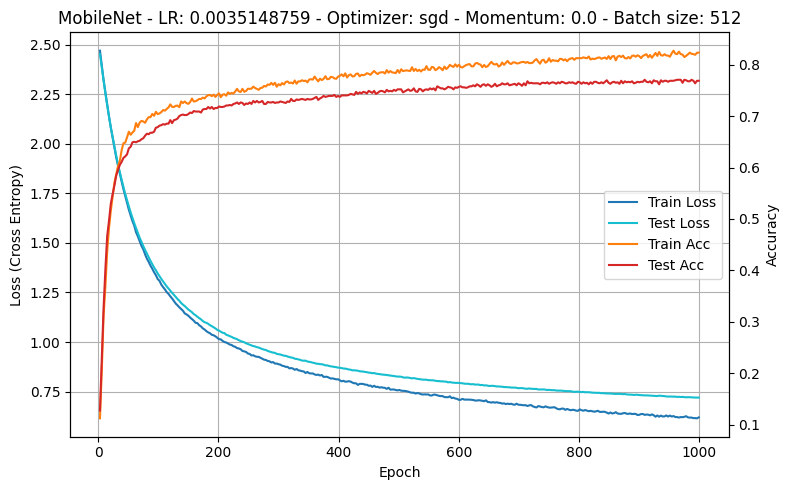

In [4]:
# Plot single run of MobileNet
meta, df = read_metrics_csv_flexible('../outputs_mobilenet/csv/metrics_20250712_162315_mobilenet_v2.csv')

plot_single_mobilenet(meta, df)

# ViT


## Learning Rate with Stochastic Gradient Descent (SGD) with momentum = 0

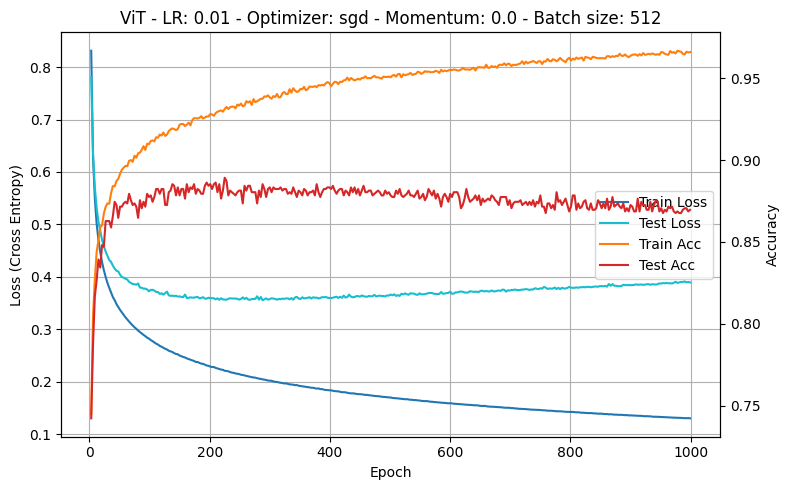

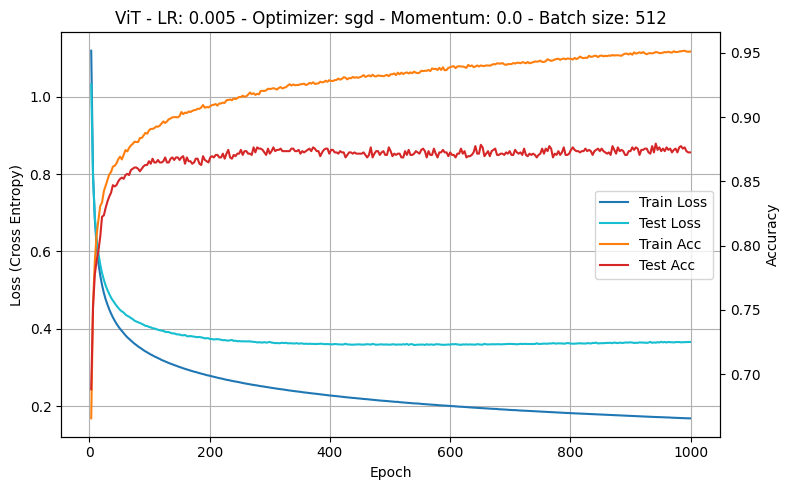

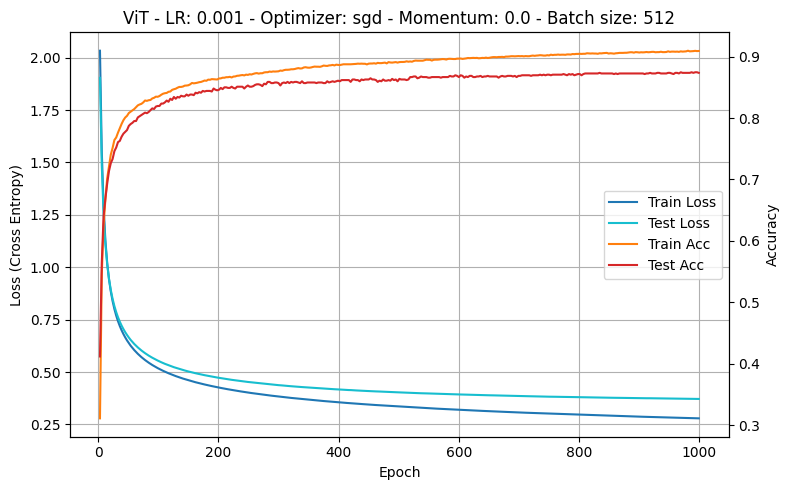

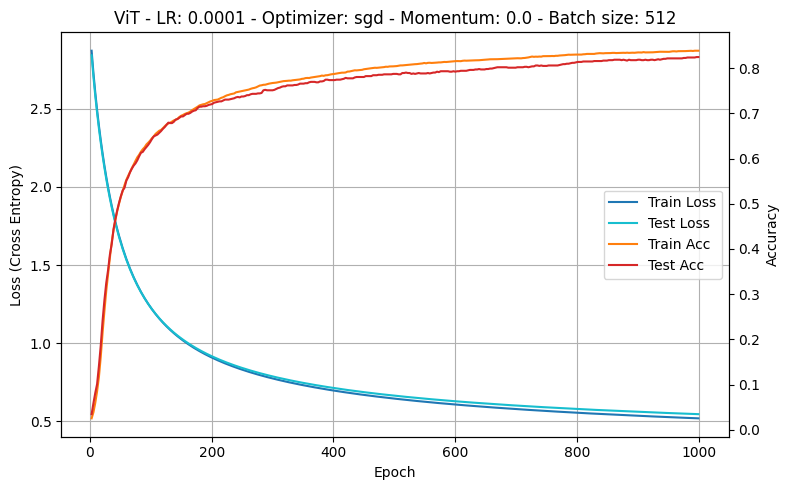

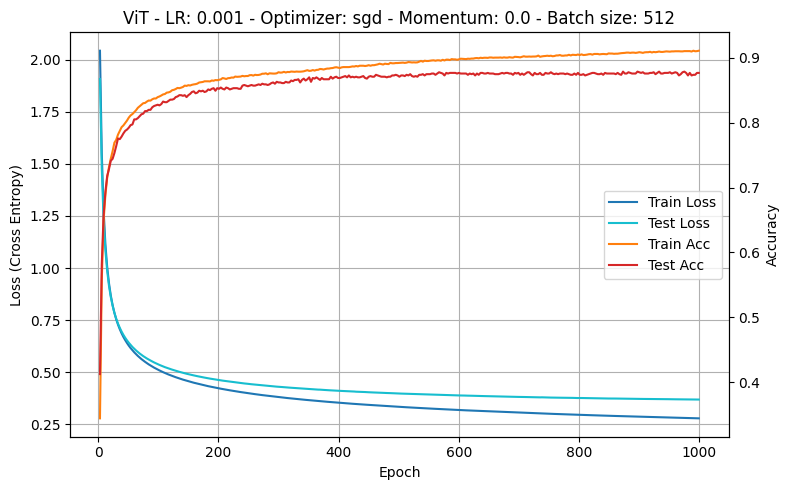

In [5]:
# Initiate dicitonaries

# 600 epochs
#lr = {
#    '0.01' : 'metrics_20250625_033820_vit_base_patch16_224.csv',
#    '0.005' : 'metrics_20250625_050825_vit_base_patch16_224.csv',
#    '0.001' : 'metrics_20250625_063841_vit_base_patch16_224.csv',
#    '0.0001' : 'metrics_20250625_080903_vit_base_patch16_224.csv'
#}

# 1000 epochs
lr = {
    '0.01' : 'metrics_20250708_232422_vit_base_patch16_224.csv',
    '0.005' : 'metrics_20250709_015447_vit_base_patch16_224.csv',
    '0.001' : 'metrics_20250709_042618_vit_base_patch16_224.csv',
    '0.0001' : 'metrics_20250709_065701_vit_base_patch16_224.csv',
    '0.001 Batch size: 512' : 'metrics_20250713_022545_vit_base_patch16_224.csv'
}
 
for item in lr:
    meta, df = read_metrics_csv_flexible(f"../outputs_vit/csv/{lr[item]}")
    plot_single_vit(meta, df)


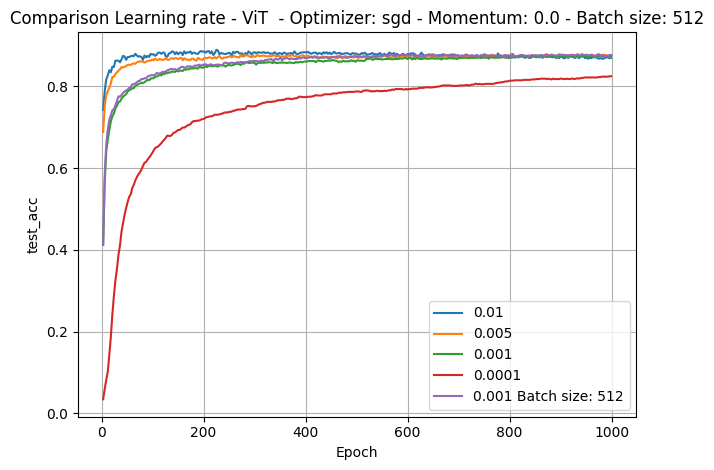

In [6]:
plot_comp_vit('test_acc', lr, 'Learning rate', 'learning_rate' )

For the ViT and Stochastic Gradient Descent we decide for a learning rate of 0.001.

## Momentum

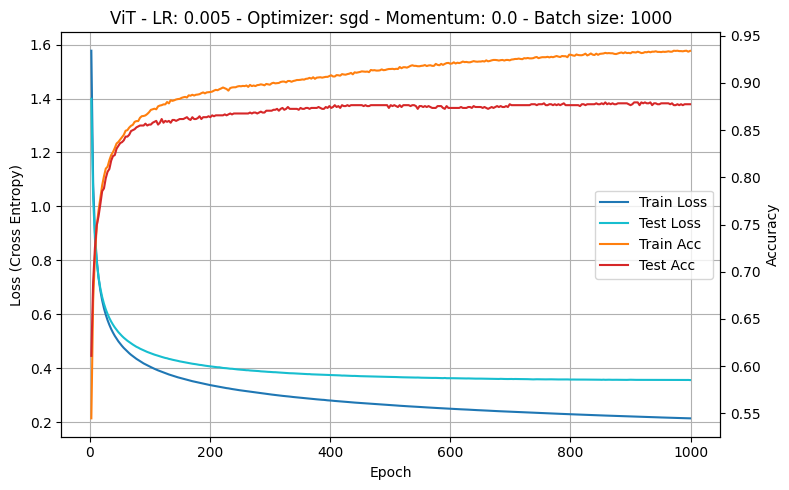

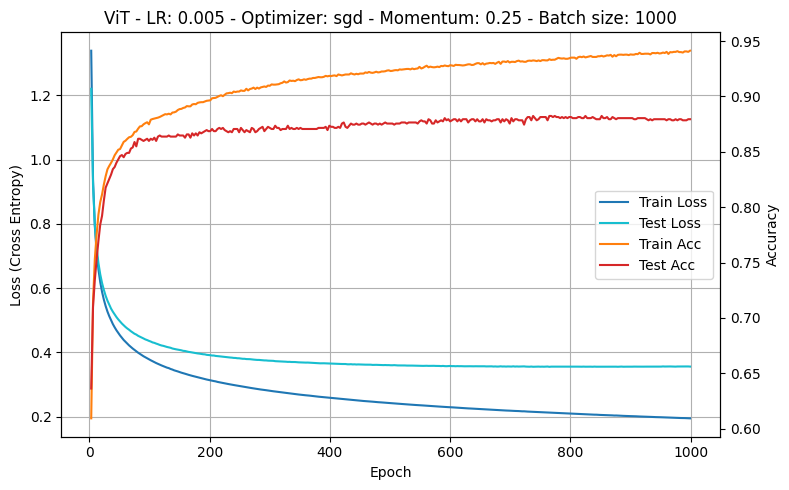

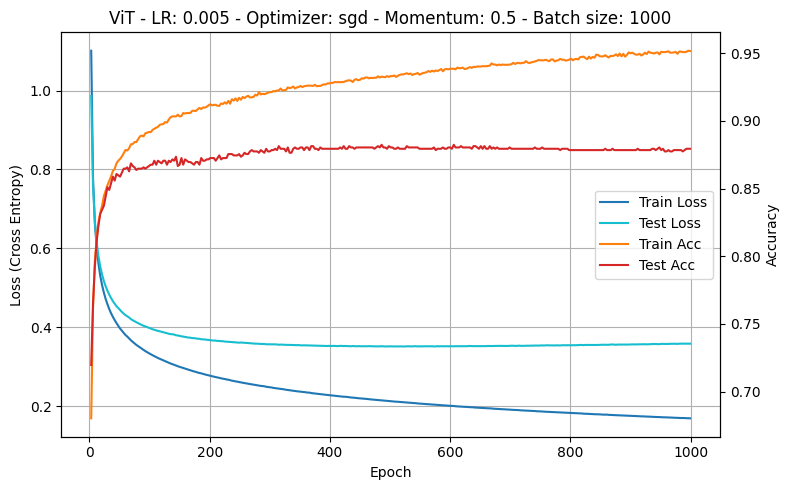

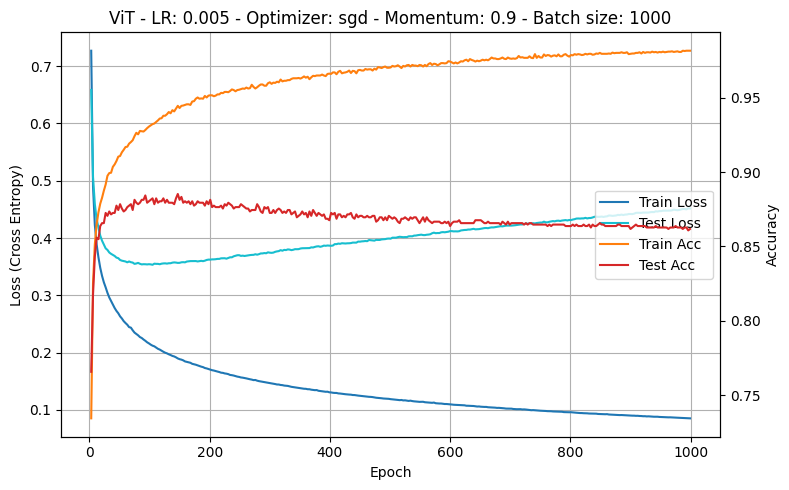

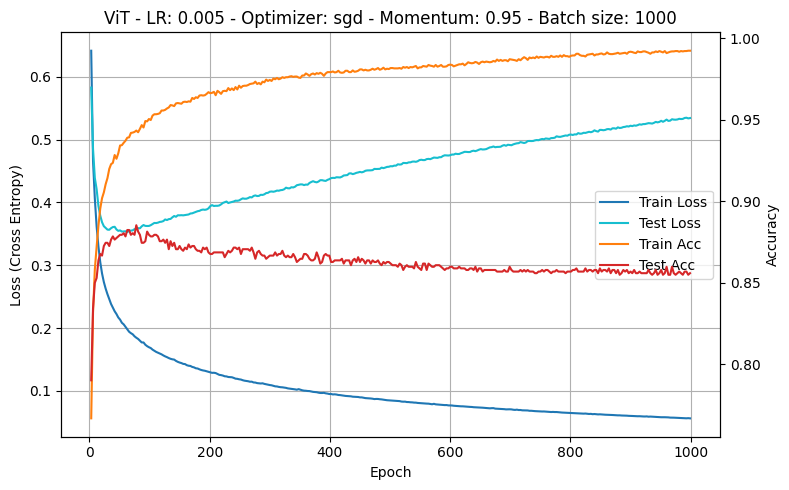

In [7]:
momentum = {
    'm_0' : 'metrics_20250630_013628_vit_base_patch16_224.csv',
    'm_25' : 'metrics_20250630_040700_vit_base_patch16_224.csv',
    'm_50' : 'metrics_20250630_063640_vit_base_patch16_224.csv',
    'm_90' : 'metrics_20250630_091410_vit_base_patch16_224.csv',
    'm_99' : 'metrics_20250630_114203_vit_base_patch16_224.csv'
}


for item in momentum:
    meta, df = read_metrics_csv_flexible(f"../outputs_vit/csv/{momentum[item]}")
    plot_single_vit(meta,df)


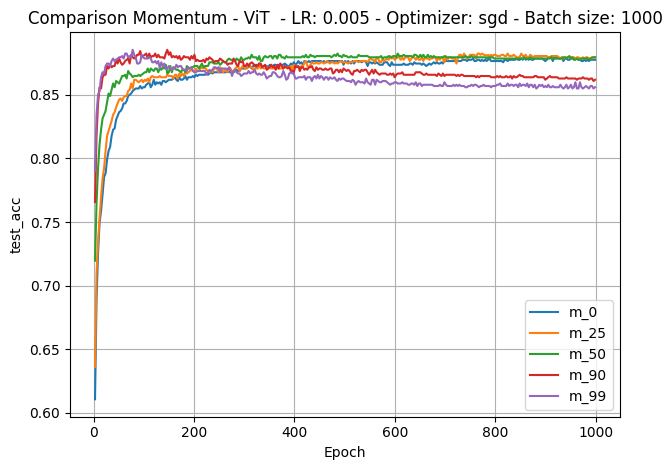

In [8]:
plot_comp_vit('test_acc', momentum, 'Momentum', 'momentum')

From this, we choose a momentum of 0 for the ViT with SGD.

## Learning rate with Adam (Batch Size 512)

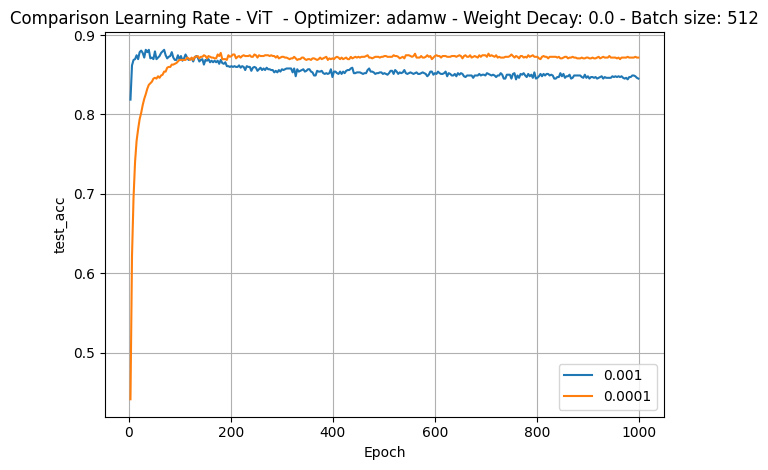

In [9]:
lr = {
    '0.001' : 'metrics_20250701_051642_vit_base_patch16_224.csv',
    '0.0001' : 'metrics_20250710_095552_vit_base_patch16_224.csv'
}
plot_comp_vit('test_acc', lr, 'Learning Rate', 'learning_rate')

Based on this plot, we choose a learning rate of 0.0001 with the option to potentially decrease it furter down to 5e-5.

## Batch size with Adam

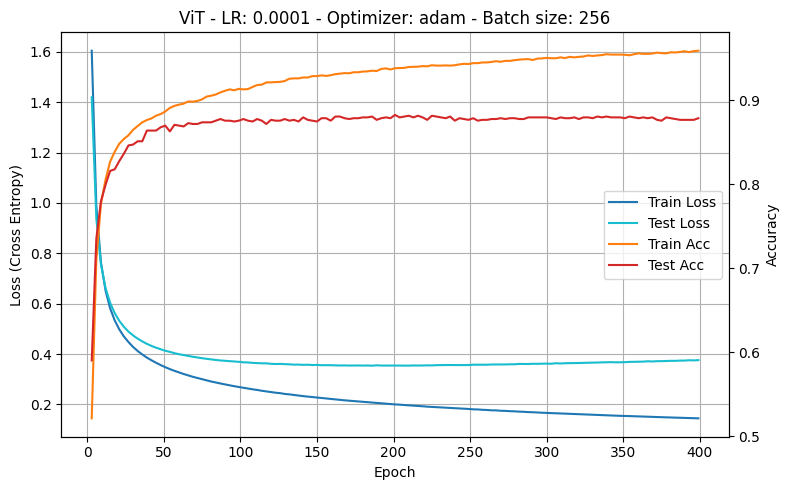

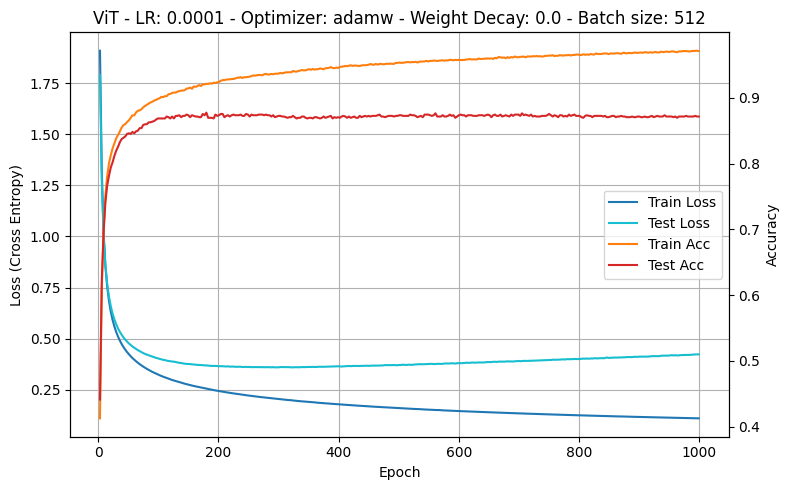

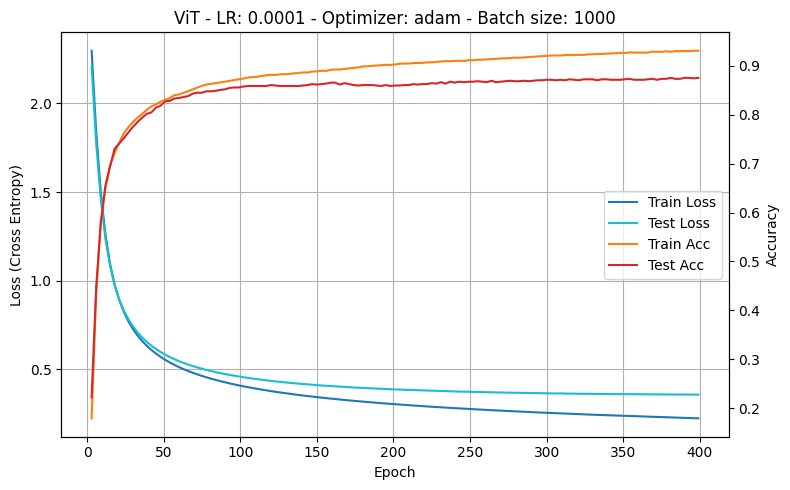

In [10]:
batch = {
    '256' : 'metrics_20250701_110232_vit_base_patch16_224.csv',
    '512' : 'metrics_20250710_095552_vit_base_patch16_224.csv',    
    '1000' : 'metrics_20250701_125256_vit_base_patch16_224.csv', 
}

for item in batch:
    meta, df = read_metrics_csv_flexible(f"../outputs_vit/csv/{batch[item]}")
    plot_single_vit(meta,df)


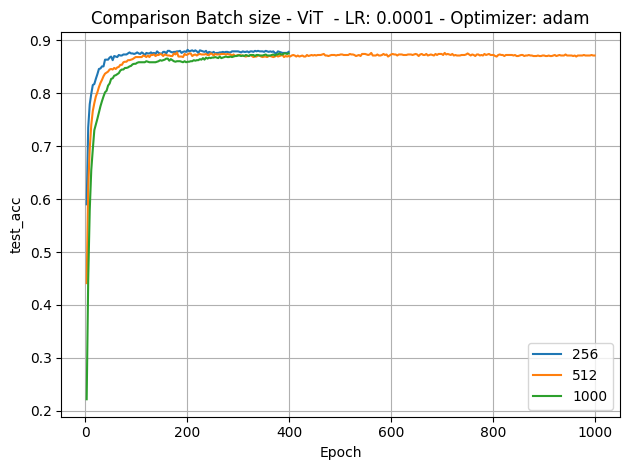

In [11]:
plot_comp_vit('test_acc', batch, 'Batch size', 'batch_size')

The Batch size does not seems to make a big difference in the long run. We choose 512 as a compromise, for smooth but faster evaluation.

## Adam Weights

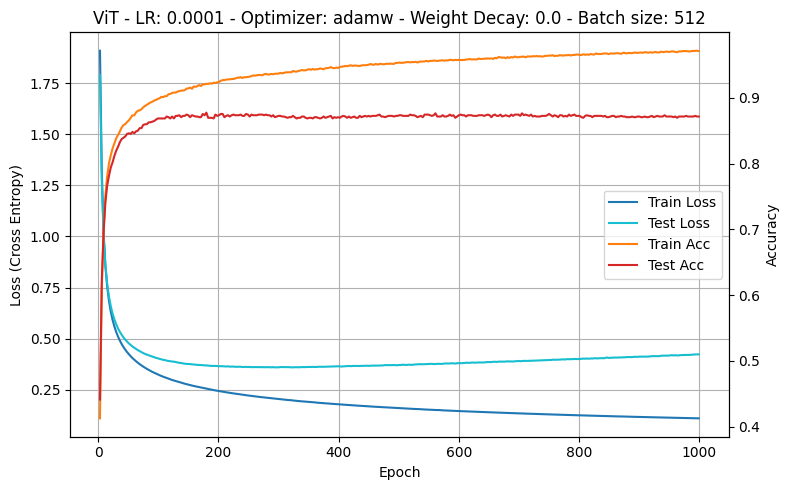

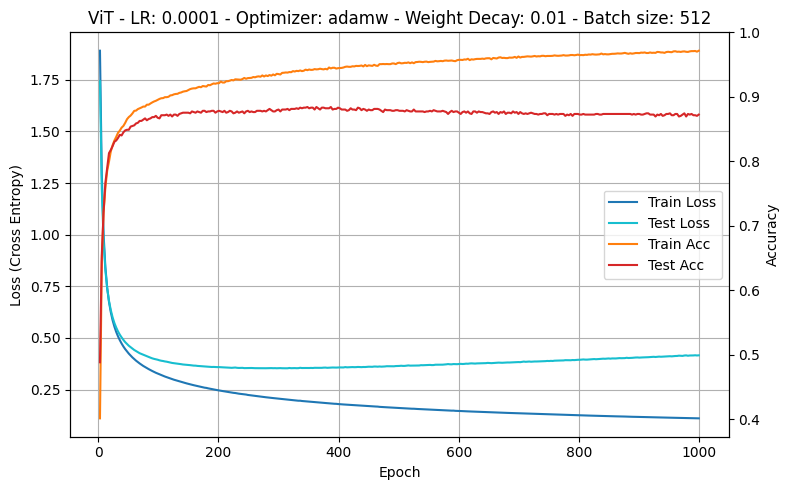

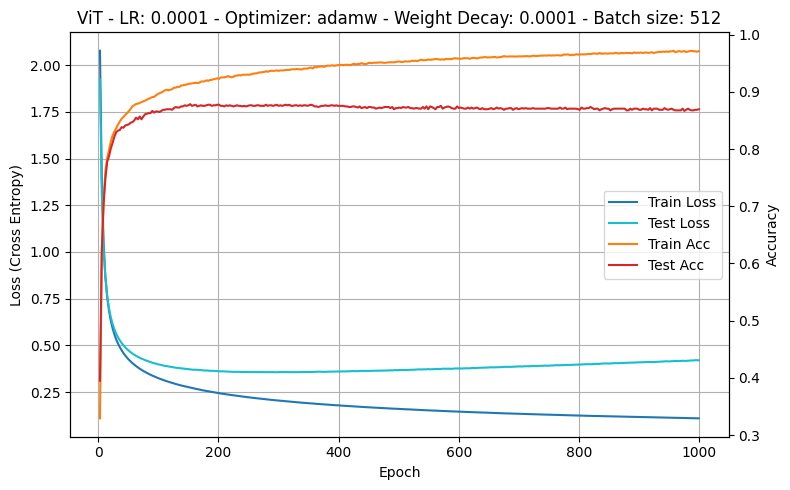

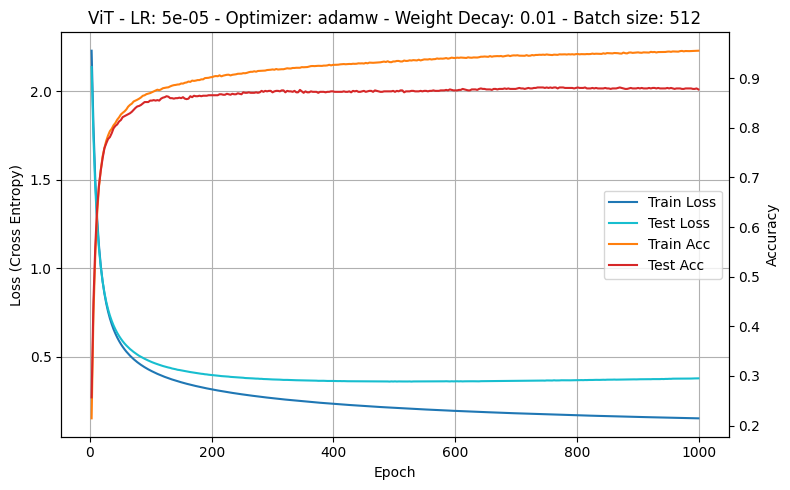

In [12]:
# Learning rate 0.0001 (mostly)
aw = {
    '0' : 'metrics_20250710_095552_vit_base_patch16_224.csv',
    '0.01': 'metrics_20250710_123440_vit_base_patch16_224.csv', 
    '0.0001' : 'metrics_20250710_150559_vit_base_patch16_224.csv',
    '0.01 LR 5e-05': 'metrics_20250711_112344_vit_base_patch16_224.csv'
}

# Different learning rates 0.001
#aw = {
#    '1e-06' : 'metrics_20250710_005156_vit_base_patch16_224.csv',
#    '0.0001' : 'metrics_20250709_222544_vit_base_patch16_224.csv',
#    '0.01' : 'metrics_20250709_195853_vit_base_patch16_224.csv', 
#    '0' : 'metrics_20250709_173244_vit_base_patch16_224.csv',
#
#}

for item in aw:
    meta, df = read_metrics_csv_flexible(f"../outputs_vit/csv/{aw[item]}")
    plot_single_vit(meta, df)


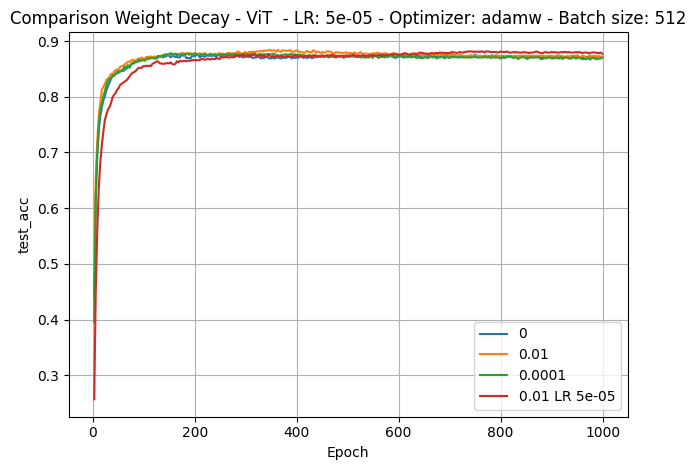

In [13]:
plot_comp_vit('test_acc', aw, 'Weight Decay', 'weight_decay')

The weight decay does not change a lot. However one run with changed learning rate and weight decay increase the accuracy. That's why we stick to LR: 5e-5 and weight decay of 0.01.

## Optimizer: Adam vs. SGD vs. AdamW

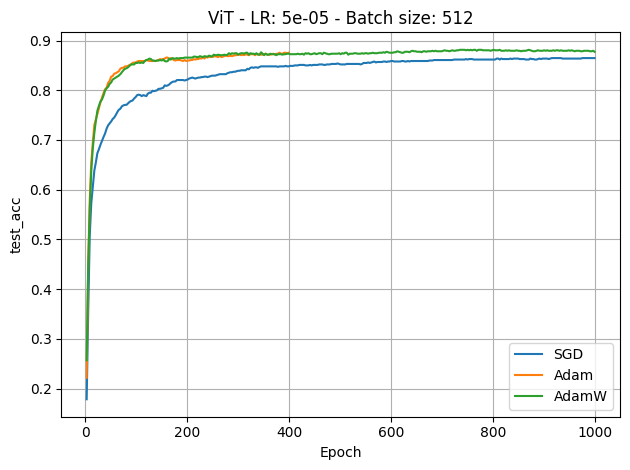

In [14]:
# Comparing the best runs of all three optimizers
opt = {
    'sgd' : 'metrics_20250630_175645_vit_base_patch16_224.csv',
    #'adam' : 'metrics_20250630_202854_vit_base_patch16_224.csv', 
    'adamw' : 'metrics_20250711_112344_vit_base_patch16_224.csv', 
    'adam' : 'metrics_20250701_125256_vit_base_patch16_224.csv', 

}

meta_sgd, df_sgd = read_metrics_csv_flexible(f"../outputs_vit/csv/{opt['sgd']}")
meta_adam, df_adam = read_metrics_csv_flexible(f"../outputs_vit/csv/{opt['adam']}")
meta_adamw, df_adamw = read_metrics_csv_flexible(f"../outputs_vit/csv/{opt['adamw']}")
quantity = "test_acc"

df_sgd = df_sgd.dropna()
df_adam = df_adam.dropna()
df_adamw = df_adamw.dropna()

plt.plot(df_sgd['epoch'], df_sgd[quantity], label = 'SGD')
plt.plot(df_adam['epoch'],df_adam[quantity], label = "Adam")
plt.plot(df_adamw['epoch'],df_adamw[quantity], label = "AdamW")

plt.xlabel('Epoch')
plt.ylabel(f'{quantity}')
plt.title(f"ViT - LR: {meta['learning_rate']} - Batch size: {meta['batch_size']}")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

# Resnet50

For Resnet, we stay at a batch size of 512, 1000 epochs and a momentum of 0. For a more thorough analysis we would need to vary this again for Resnet, but do to computational limitations, we fix it here.

## Learning Rate wit SGD (Momentum = 0)

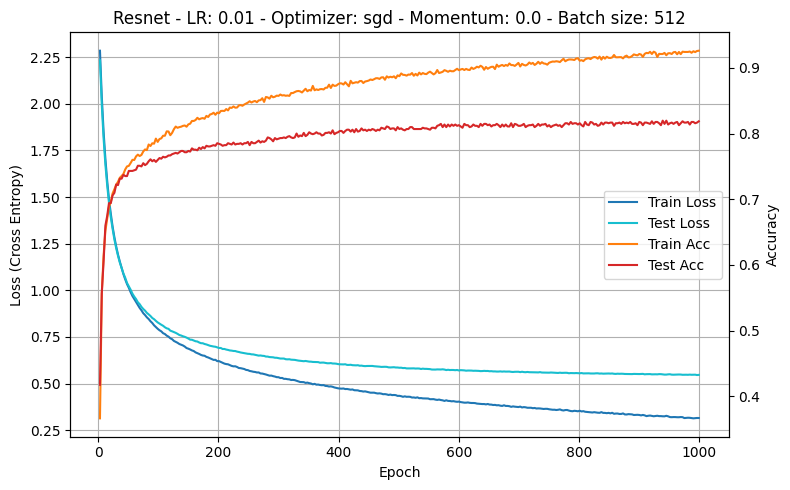

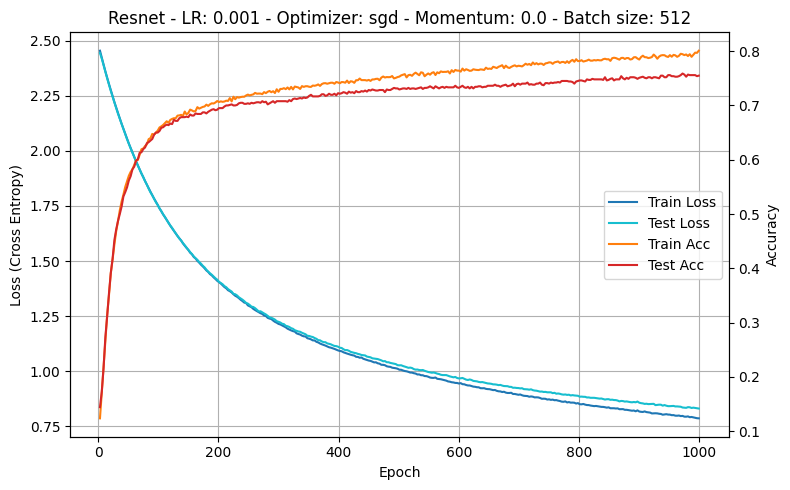

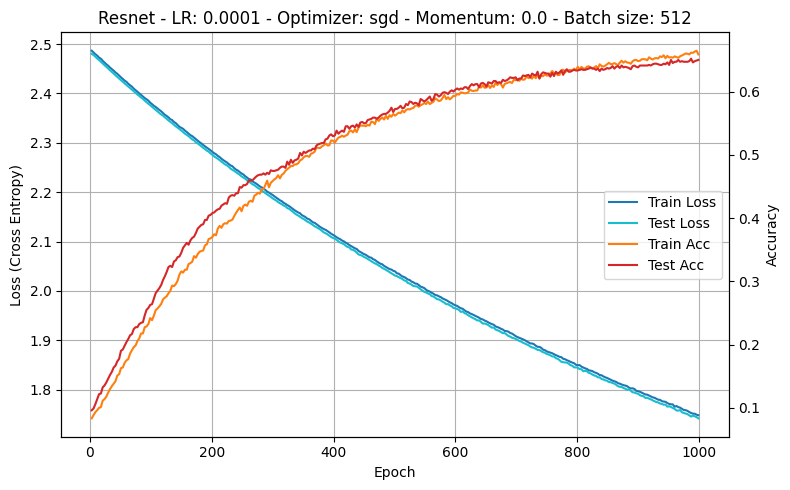

In [15]:
lr = {
    '0.01' : 'metrics_20250712_193535_resnet50.csv',
    '0.001' : 'metrics_20250712_213059_resnet50.csv',
    '0.0001' : 'metrics_20250712_232715_resnet50.csv'
}

for item in lr:
    meta, df = read_metrics_csv_flexible(f"../outputs_resnet/csv/{lr[item]}")
    plot_single_resnet(meta, df)


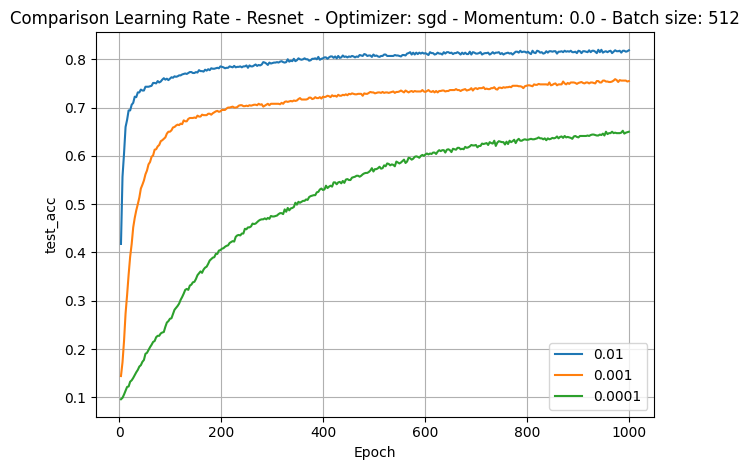

In [16]:
plot_comp_resnet('test_acc', lr, 'Learning Rate', 'learning_rate')

We choose a learning rate of 0.01 for Resnet with SGD.

## Learning Rate with Adam


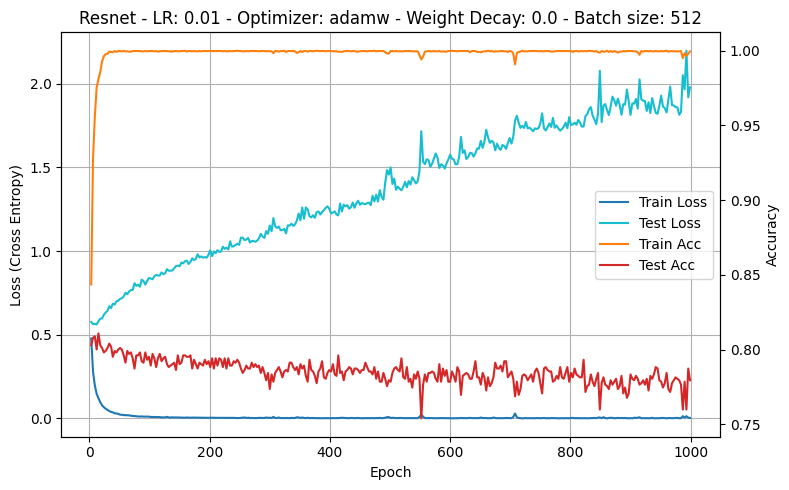

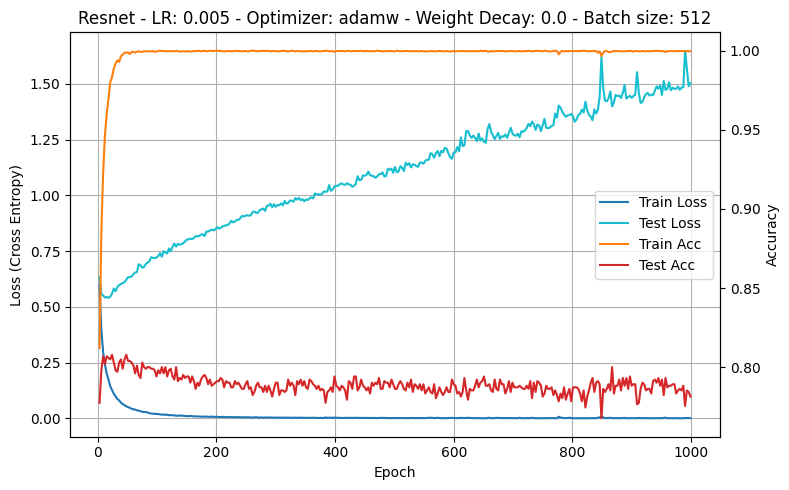

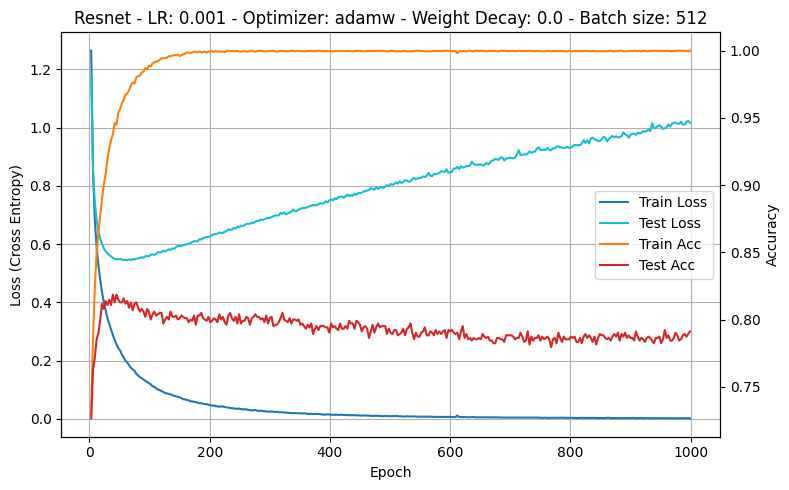

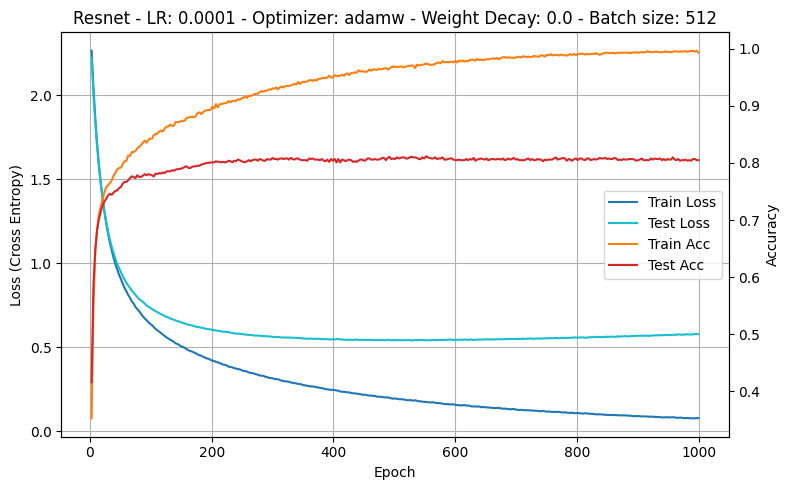

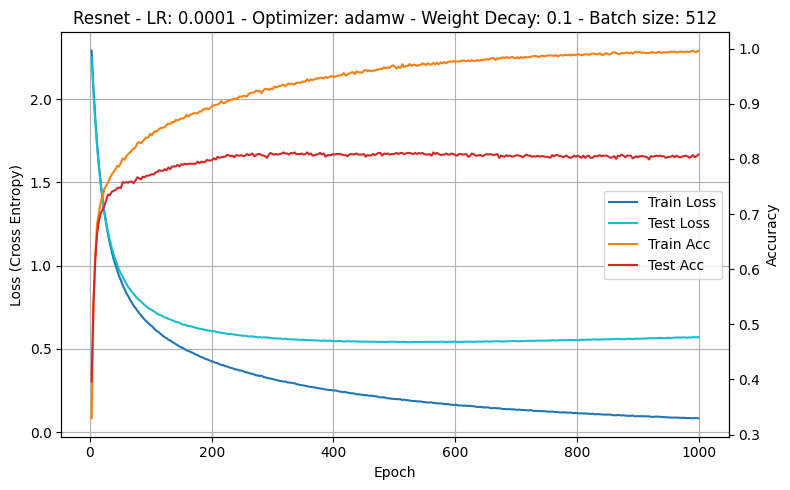

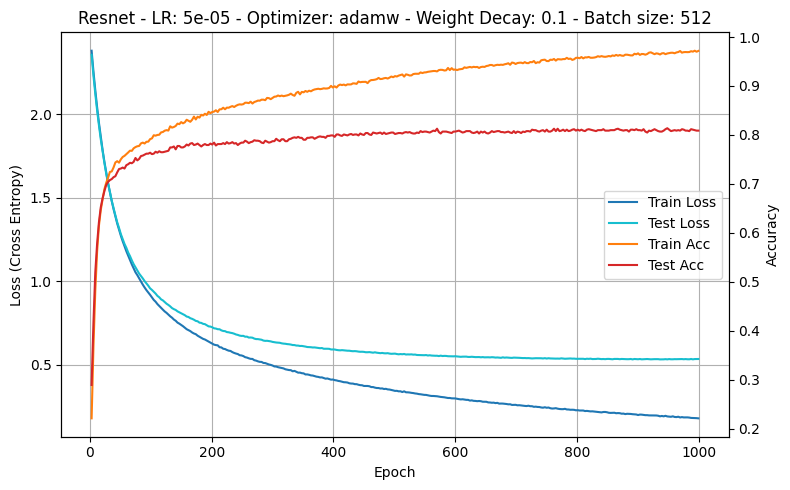

In [17]:
# 1000 epochs - Weight decay is at 0 , or specified else
lr = {
    '0.01' : 'metrics_20250711_022743_resnet50.csv',
    '0.005' : 'metrics_20250711_041635_resnet50.csv',
    '0.001' : 'metrics_20250711_060520_resnet50.csv',
    '0.0001' : 'metrics_20250711_075523_resnet50.csv', 
    '0.0001 WD 0.1' : 'metrics_20250711_202001_resnet50.csv', 
    '5e-5 WD 0.1' : 'metrics_20250712_122349_resnet50.csv'
}
 
for item in lr:
    meta, df = read_metrics_csv_flexible(f"../outputs_resnet/csv/{lr[item]}")
    plot_single_resnet(meta, df)


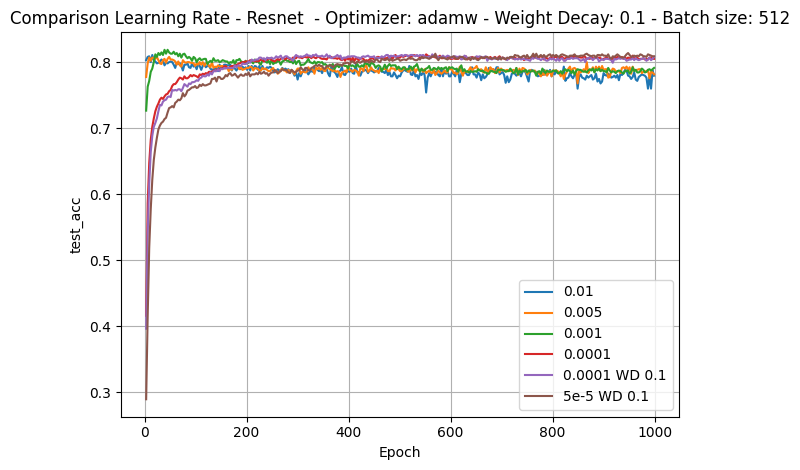

In [18]:
plot_comp_resnet('test_acc', lr, 'Learning Rate', 'learning_rate')

We stick with a learning rate of 0.0001 and a weight decay of 0.1. 

## Compare Adam and SGD

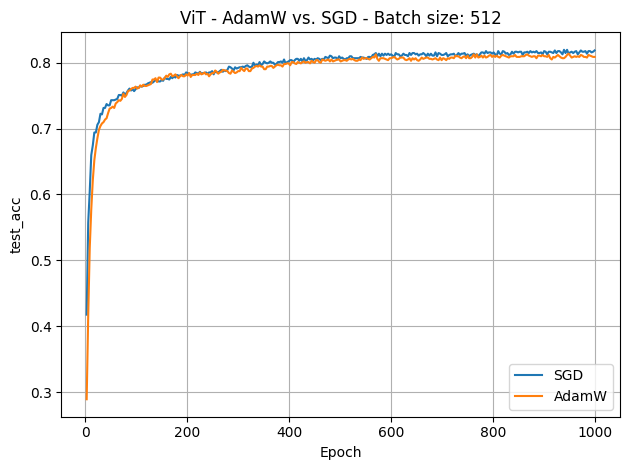

In [19]:
# Comparing the best runs of both optimizers
opt = {
    'sgd' : 'metrics_20250712_193535_resnet50.csv', 
    'adamw' : 'metrics_20250712_122349_resnet50.csv'

}

meta_sgd, df_sgd = read_metrics_csv_flexible(f"../outputs_resnet/csv/{opt['sgd']}")
meta_adamw, df_adamw = read_metrics_csv_flexible(f"../outputs_resnet/csv/{opt['adamw']}")
quantity = "test_acc"

df_sgd = df_sgd.dropna()
df_adamw = df_adamw.dropna()

plt.plot(df_sgd['epoch'], df_sgd[quantity], label = 'SGD')
plt.plot(df_adamw['epoch'],df_adamw[quantity], label = "AdamW")

plt.xlabel('Epoch')
plt.ylabel(f'{quantity}')
plt.title(f"ViT - AdamW vs. SGD - Batch size: {meta['batch_size']}")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

At the end, SGD delivers slightly better results and higher epochs have the potential to increase the accuracy even further.